In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers, Model                                       #Importing the necessary libraries

In [2]:
df = pd.read_csv("transformed_data.csv")

In [3]:
print("Columns in CSV:", df.columns.tolist())
print("Number of rows:", len(df))
df.head()    # Getting an idea of the CSV file

Columns in CSV: ['X Position', 'Y Position', 'Time', 'Theta_radians', 'Theta_degrees']
Number of rows: 1976


,X Position,Y Position,Time,Theta_radians,Theta_degrees
0,2.794193,-9.226087,0.000000,-0.059761,-3.424043
1,-3.926325,347.761076,0.016667,-0.061498,-3.523592
2,-0.142590,353.899753,0.033333,-0.060520,-3.467543
3,4.604890,361.073415,0.050000,-0.059293,-3.397223
4,4.604890,361.073415,0.066667,-0.059293,-3.397223


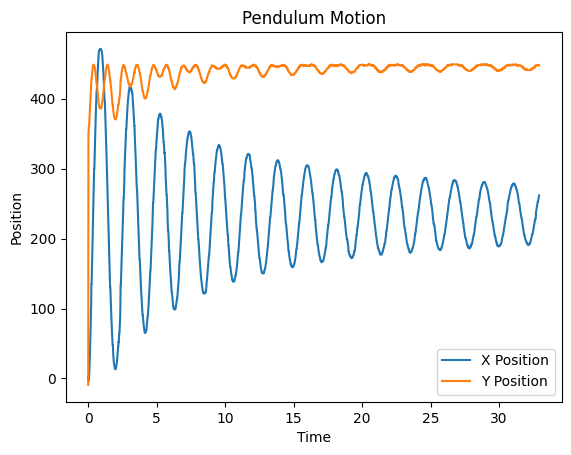

In [4]:
plt.plot(df["Time"], df["X Position"], label='X Position')
plt.plot(df["Time"], df["Y Position"], label='Y Position')

plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Pendulum Motion')
plt.legend()   # plotting to see nature of trials
plt.show()

Data with theta saved to 'transformed_data_with_theta.csv'


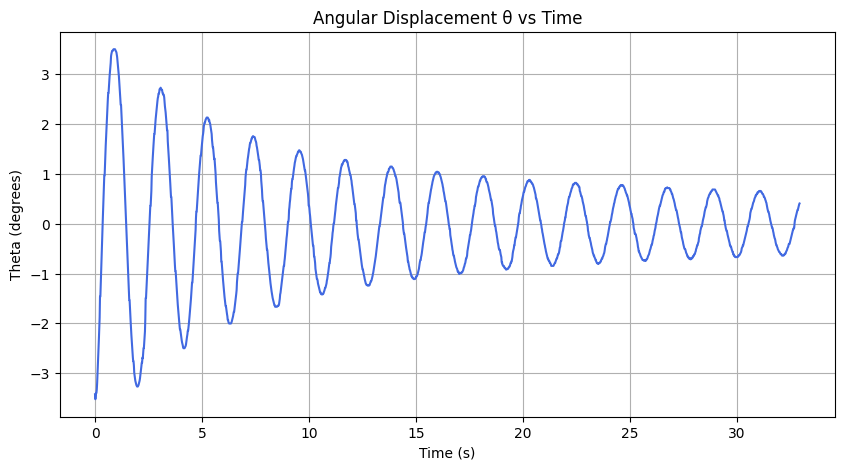

Equilibrium x = 234.2385
Theta range: -3.52° to 3.50°
Theta radians range: -0.0615 to 0.0611 rad


In [5]:
# Load data
df = pd.read_csv("transformed_data.csv")
t = df["Time"].values
x = df["X Position"].values

# Step 1: Calculate equilibrium position (mean x)
x_eq = np.mean(x)

# Step 2: Use your known length
L = 3875.1496063

# Step 3: Compute theta(t) using sin and arcsin
sin_theta = (x - x_eq) / L
theta = np.arcsin(sin_theta)

# Convert to degrees
theta_deg = np.degrees(theta)

# Add theta columns to the original dataframe
df['Theta_radians'] = theta
df['Theta_degrees'] = theta_deg

# Save the updated dataframe with all original data plus theta
df.to_csv('transformed_data.csv', index=False)
print("Data with theta saved to 'transformed_data_with_theta.csv'")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(t, theta_deg, color='royalblue', lw=1.5)
plt.xlabel("Time (s)")
plt.ylabel("Theta (degrees)")
plt.title("Angular Displacement θ vs Time")
plt.grid(True)
plt.show()

print(f"Equilibrium x = {x_eq:.4f}")
print(f"Theta range: {np.min(theta_deg):.2f}° to {np.max(theta_deg):.2f}°")
print(f"Theta radians range: {np.min(theta):.4f} to {np.max(theta):.4f} rad")

Starting training...
Epoch 0001 | total=4.599e+01 | data=7.324e-02 | pde=5.063e+00 | ic=1.367e-02
Epoch 0100 | total=2.526e-01 | data=4.984e-04 | pde=4.705e-03 | ic=2.119e-06
Epoch 0200 | total=2.482e-01 | data=4.886e-04 | pde=3.869e-03 | ic=4.004e-06
Epoch 0300 | total=2.457e-01 | data=4.842e-04 | pde=3.604e-03 | ic=3.566e-06
Epoch 0400 | total=2.429e-01 | data=4.791e-04 | pde=3.366e-03 | ic=3.284e-06
Epoch 0500 | total=2.399e-01 | data=4.736e-04 | pde=3.127e-03 | ic=3.031e-06
Epoch 0600 | total=2.365e-01 | data=4.674e-04 | pde=2.887e-03 | ic=2.791e-06
Epoch 0700 | total=2.329e-01 | data=4.606e-04 | pde=2.644e-03 | ic=2.555e-06
Epoch 0800 | total=2.289e-01 | data=4.531e-04 | pde=2.398e-03 | ic=2.317e-06
Epoch 0900 | total=2.244e-01 | data=4.445e-04 | pde=2.146e-03 | ic=2.071e-06
Epoch 1000 | total=2.192e-01 | data=4.346e-04 | pde=1.886e-03 | ic=1.813e-06
Epoch 1100 | total=2.131e-01 | data=4.231e-04 | pde=1.620e-03 | ic=1.542e-06
Epoch 1200 | total=2.060e-01 | data=4.094e-04 | pde=1.3

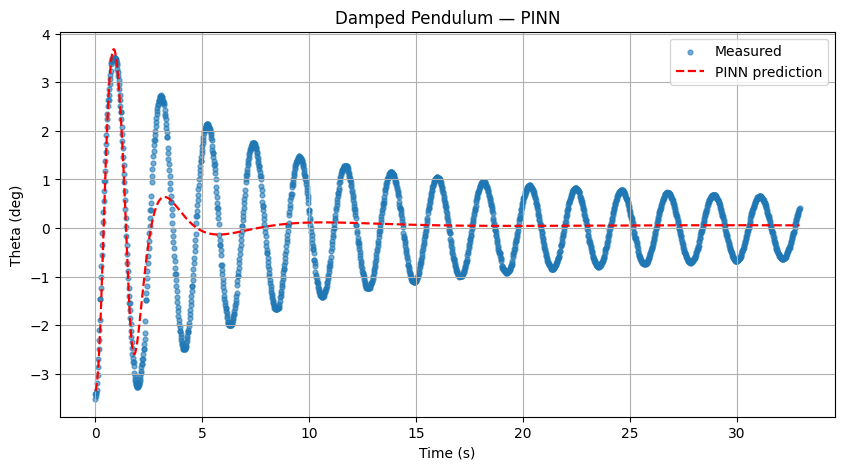

In [6]:
# ======================================================
# Corrected JAX + Equinox PINN for Damped Pendulum
# ======================================================
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.tree_util as jtu

# ------------------ 1. Load data ------------------
df = pd.read_csv("transformed_data.csv")
t_np = df["Time"].to_numpy(dtype=np.float32).reshape(-1, 1)
theta_deg_np = df["Theta_degrees"].to_numpy(dtype=np.float32).reshape(-1, 1)
theta_np = np.deg2rad(theta_deg_np)   # radians
t_np -= t_np.min()

t_data = jnp.array(t_np)               # (N,1)
theta_data = jnp.array(theta_np)       # (N,1)

# ------------------ 2. Parameters ------------------
g = 9.81
L = 1.16
gamma = 0.143
theta0 = float(theta_np[0, 0])
theta_dot0 = 0.0

# ------------------ 3. Simple MLP (returns scalar) ------------------
class MLP(eqx.Module):
    layers: list

    def __init__(self, key, in_size=1, out_size=1, width=64, depth=4):
        keys = jax.random.split(key, depth + 1)
        self.layers = []
        for i in range(depth):
            self.layers.append(eqx.nn.Linear(in_size if i == 0 else width, width, key=keys[i]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, t):
        # Accept t as a 1D array of shape (1,) or scalar-like array
        x = t
        for lyr in self.layers[:-1]:
            x = jnp.tanh(lyr(x))
        out = self.layers[-1](x)   # out has shape (1,) typically
        return jnp.squeeze(out)    # FORCE a true scalar shape ()

# ------------------ 4. Physics residual (uses scalar-output model) ------------------
def physics_residual(model, t):
    # t: (N,1) or (N,)
    t_flat = t.flatten()

    def f(s):
        # ensure input is shape (1,)
        return model(jnp.array([s]))   # model returns scalar ()

    # vectorize over points
    theta_v = jax.vmap(f)(t_flat)               # (N,) scalars
    theta_t_v = jax.vmap(jax.grad(f))(t_flat)   # (N,)
    theta_tt_v = jax.vmap(jax.grad(jax.grad(f)))(t_flat)  # (N,)

    # residual: θ'' + γ θ' + (g/L) sin θ = 0
    res_v = theta_tt_v + gamma * theta_t_v + (g / L) * jnp.sin(theta_v)

    # reshape to (N,1) to match theta_data
    return theta_v.reshape(-1, 1), theta_t_v.reshape(-1, 1), theta_tt_v.reshape(-1, 1), res_v.reshape(-1, 1)

# ------------------ 5. Loss ------------------
def loss_fn(model, t, theta_obs, w_data=500.0, w_phys=0.5, w_ic=500.0):
    theta_pred, _, _, res = physics_residual(model, t)
    data_loss = jnp.mean((theta_pred - theta_obs) ** 2)
    phys_loss = jnp.mean(res ** 2)

    # IC: theta(0) and theta_dot(0)
    theta0_pred = model(jnp.array([0.0]))               # scalar
    theta_dot0_pred = jax.grad(lambda s: model(jnp.array([s])))(0.0)
    ic_loss = (theta0_pred - theta0) ** 2 + (theta_dot0_pred - theta_dot0) ** 2

    total = w_data * data_loss + w_phys * phys_loss + w_ic * ic_loss
    return total, (data_loss, phys_loss, ic_loss)

# ------------------ 6. Setup model and optimizer ------------------
key = jax.random.PRNGKey(0)
model = MLP(key, in_size=1, out_size=1, width=128, depth=3)

# Partition (no static parts here, but keep pattern)
diff_model, static_model = eqx.partition(model, eqx.is_inexact_array)

opt = optax.adam(5e-4)
opt_state = opt.init(eqx.filter(diff_model, eqx.is_inexact_array))

# Filtered value_and_grad wrapper
fvag = eqx.filter_value_and_grad(lambda dm, sm: loss_fn(eqx.combine(dm, sm), t_data, theta_data), has_aux=True)

@eqx.filter_jit
def step(opt_state, diff_m, static_m):
    (loss_val, aux), grads = fvag(diff_m, static_m)
    updates, opt_state = opt.update(grads, opt_state, eqx.filter(diff_m, eqx.is_inexact_array))
    diff_m = eqx.apply_updates(diff_m, updates)
    return opt_state, diff_m, loss_val, aux

# ------------------ 7. Training loop ------------------
n_epochs = 10000
print("Starting training...")
for epoch in range(1, n_epochs + 1):
    opt_state, diff_model, loss_val, aux = step(opt_state, diff_model, static_model)
    if epoch % 100 == 0 or epoch == 1:
        d, p, ic = aux
        print(f"Epoch {epoch:04d} | total={float(loss_val):.3e} | data={float(d):.3e} | pde={float(p):.3e} | ic={float(ic):.3e}")

# ------------------ 8. Evaluate & plot ------------------
trained = eqx.combine(diff_model, static_model)
t_flat = t_np.flatten()
theta_pred = jax.vmap(lambda s: trained(jnp.array([s])))(t_flat)  # (N,)
theta_pred_deg = np.degrees(np.array(theta_pred).flatten())
theta_meas_deg = theta_deg_np.flatten()

plt.figure(figsize=(10,5))
plt.scatter(t_flat, theta_meas_deg, s=12, alpha=0.6, label="Measured")
plt.plot(t_flat, theta_pred_deg, 'r--', lw=1.6, label="PINN prediction")
plt.xlabel("Time (s)"); plt.ylabel("Theta (deg)")
plt.legend(); plt.grid(True); plt.title("Damped Pendulum — PINN")
plt.show()

In [7]:
import pandas as pd
df = pd.read_csv("transformed_data.csv")
print("Rows:", len(df))
print("Time range:", df["Time"].min(), "to", df["Time"].max())
print(df.head())


Rows: 1976
Time range: 0.0 to 32.916666666666664
   X Position  Y Position      Time  Theta_radians  Theta_degrees
0    2.794193   -9.226087  0.000000      -0.059761      -3.424043
1   -3.926325  347.761076  0.016667      -0.061498      -3.523592
2   -0.142590  353.899753  0.033333      -0.060520      -3.467543
3    4.604890  361.073415  0.050000      -0.059293      -3.397223
4    4.604890  361.073415  0.066667      -0.059293      -3.397223


In [8]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("transformed_data.csv")

# Target number of points
target_points = 250

# Uniformly spaced times across the original range
time_new = np.linspace(df["Time"].min(), df["Time"].max(), target_points)

# Interpolate Theta_degrees (or Theta_radians if preferred)
theta_interp = np.interp(time_new, df["Time"], df["Theta_degrees"])

# Create resampled dataframe
df_resampled = pd.DataFrame({
    "Time": time_new,
    "Theta_degrees": theta_interp
})

df_resampled.to_csv("resampled_data.csv", index=False)
print(df_resampled.head(), "\nRows:", len(df_resampled))

       Time  Theta_degrees
0  0.000000      -3.424043
1  0.132195      -2.873245
2  0.264391      -1.260459
3  0.396586       0.507832
4  0.528782       1.857742 
Rows: 250


Starting training...
Epoch 0001 | total=4.593e+01 | data=7.314e-02 | pde=5.055e+00 | ic=1.367e-02
Epoch 0100 | total=2.518e-01 | data=4.966e-04 | pde=4.992e-03 | ic=2.085e-06
Epoch 0200 | total=2.474e-01 | data=4.867e-04 | pde=4.135e-03 | ic=3.986e-06
Epoch 0300 | total=2.449e-01 | data=4.823e-04 | pde=3.859e-03 | ic=3.549e-06
Epoch 0400 | total=2.421e-01 | data=4.774e-04 | pde=3.609e-03 | ic=3.269e-06
Epoch 0500 | total=2.391e-01 | data=4.719e-04 | pde=3.357e-03 | ic=3.019e-06
Epoch 0600 | total=2.358e-01 | data=4.658e-04 | pde=3.103e-03 | ic=2.781e-06
Epoch 0700 | total=2.323e-01 | data=4.591e-04 | pde=2.844e-03 | ic=2.547e-06
Epoch 0800 | total=2.283e-01 | data=4.517e-04 | pde=2.581e-03 | ic=2.311e-06
Epoch 0900 | total=2.238e-01 | data=4.433e-04 | pde=2.309e-03 | ic=2.068e-06
Epoch 1000 | total=2.187e-01 | data=4.335e-04 | pde=2.028e-03 | ic=1.813e-06
Epoch 1100 | total=2.127e-01 | data=4.221e-04 | pde=1.738e-03 | ic=1.545e-06
Epoch 1200 | total=2.057e-01 | data=4.087e-04 | pde=1.4

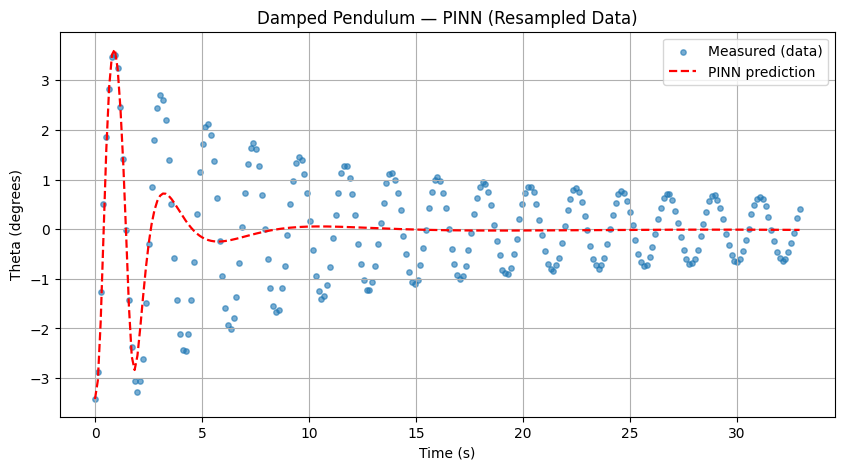

In [12]:

# ------------------ 1. Load data ------------------
df = pd.read_csv("resampled_data.csv")
t_np = df["Time"].to_numpy(dtype=np.float32).reshape(-1, 1)
theta_deg_np = df["Theta_degrees"].to_numpy(dtype=np.float32).reshape(-1, 1)
theta_np = np.deg2rad(theta_deg_np)  # radians
t_np -= t_np.min()

t_data = jnp.array(t_np)
theta_data = jnp.array(theta_np)

# ------------------ 2. Parameters ------------------
g = 9.81
L = 1.16
gamma = 0.143
theta0 = float(theta_np[0, 0])
theta_dot0 = 0.0

# ------------------ 3. MLP ------------------
class MLP(eqx.Module):
    layers: list

    def __init__(self, key, in_size=1, out_size=1, width=64, depth=4):
        keys = jax.random.split(key, depth + 1)
        self.layers = []
        for i in range(depth):
            self.layers.append(eqx.nn.Linear(in_size if i == 0 else width, width, key=keys[i]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, t):
        x = t
        for lyr in self.layers[:-1]:
            x = jnp.tanh(lyr(x))
        out = self.layers[-1](x)
        return jnp.squeeze(out)

# ------------------ 4. Physics residual ------------------
def physics_residual(model, t):
    t_flat = t.flatten()

    def f(s):
        return model(jnp.array([s]))

    theta_v = jax.vmap(f)(t_flat)
    theta_t_v = jax.vmap(jax.grad(f))(t_flat)
    theta_tt_v = jax.vmap(jax.grad(jax.grad(f)))(t_flat)

    res_v = theta_tt_v + gamma * theta_t_v + (g / L) * jnp.sin(theta_v)
    return theta_v.reshape(-1, 1), theta_t_v.reshape(-1, 1), theta_tt_v.reshape(-1, 1), res_v.reshape(-1, 1)

# ------------------ 5. Loss ------------------
def loss_fn(model, t, theta_obs, w_data=500.0, w_phys=0.5, w_ic=500.0):
    theta_pred, _, _, res = physics_residual(model, t)
    data_loss = jnp.mean((theta_pred - theta_obs) ** 2)
    phys_loss = jnp.mean(res ** 2)
    theta0_pred = model(jnp.array([0.0]))
    theta_dot0_pred = jax.grad(lambda s: model(jnp.array([s])))(0.0)
    ic_loss = (theta0_pred - theta0) ** 2 + (theta_dot0_pred - theta_dot0) ** 2
    total = w_data * data_loss + w_phys * phys_loss + w_ic * ic_loss
    return total, (data_loss, phys_loss, ic_loss)

# ------------------ 6. Setup model and optimizer ------------------
key = jax.random.PRNGKey(0)
model = MLP(key, in_size=1, out_size=1, width=128, depth=3)
diff_model, static_model = eqx.partition(model, eqx.is_inexact_array)
opt = optax.adam(5e-4)
opt_state = opt.init(eqx.filter(diff_model, eqx.is_inexact_array))

fvag = eqx.filter_value_and_grad(lambda dm, sm: loss_fn(eqx.combine(dm, sm), t_data, theta_data), has_aux=True)

@eqx.filter_jit
def step(opt_state, diff_m, static_m):
    (loss_val, aux), grads = fvag(diff_m, static_m)
    updates, opt_state = opt.update(grads, opt_state, eqx.filter(diff_m, eqx.is_inexact_array))
    diff_m = eqx.apply_updates(diff_m, updates)
    return opt_state, diff_m, loss_val, aux

# ------------------ 7. Training loop ------------------
n_epochs = 10000
print("Starting training...")
for epoch in range(1, n_epochs + 1):
    opt_state, diff_model, loss_val, aux = step(opt_state, diff_model, static_model)
    if epoch % 100 == 0 or epoch == 1:
        d, p, ic = aux
        print(f"Epoch {epoch:04d} | total={float(loss_val):.3e} | data={float(d):.3e} | pde={float(p):.3e} | ic={float(ic):.3e}")

# ------------------ 8. Evaluate & print ------------------
trained = eqx.combine(diff_model, static_model)
t_flat = t_np.flatten()
theta_pred = jax.vmap(lambda s: trained(jnp.array([s])))(t_flat)
theta_pred_deg = np.degrees(np.array(theta_pred).flatten())
theta_meas_deg = theta_deg_np.flatten()

# Print sample comparison
comparison = np.vstack([t_flat, theta_meas_deg, theta_pred_deg]).T
print("\nSample comparison (time, measured, predicted):")
print(comparison[:10])

# ------------------ 9. Plot ------------------
plt.figure(figsize=(10,5))
plt.scatter(t_flat, theta_meas_deg, s=15, alpha=0.6, label="Measured (data)")
plt.plot(t_flat, theta_pred_deg, 'r--', lw=1.6, label="PINN prediction")
plt.xlabel("Time (s)")
plt.ylabel("Theta (degrees)")
plt.legend()
plt.grid(True)
plt.title("Damped Pendulum — PINN (Resampled Data)")
plt.show()


Starting training...
Epoch 0001 | total=3.720e+01 | data=4.840e-03 | pde=4.437e+01 | ic=2.520e-02
Epoch 0100 | total=7.224e-01 | data=5.428e-04 | pde=8.891e-01 | ic=1.295e-05
Epoch 0200 | total=4.125e-01 | data=3.397e-04 | pde=4.834e-01 | ic=1.840e-06


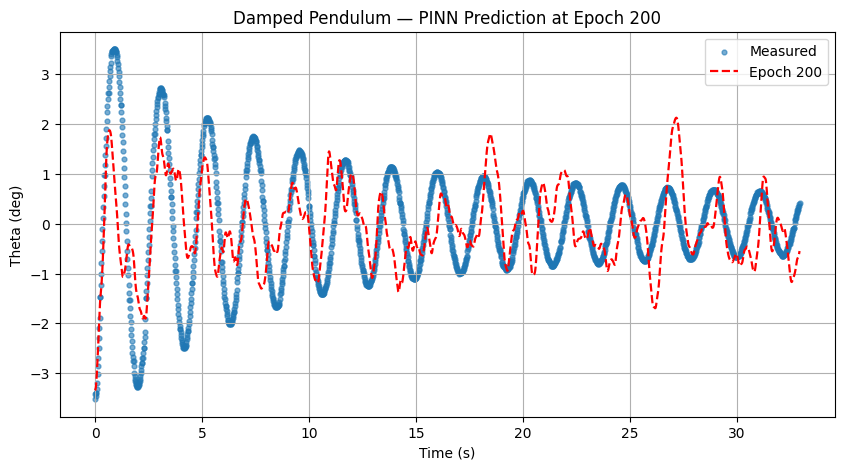

Epoch 0300 | total=2.685e-01 | data=2.093e-04 | pde=3.266e-01 | ic=9.874e-07
Epoch 0400 | total=1.850e-01 | data=1.329e-04 | pde=2.365e-01 | ic=5.357e-07


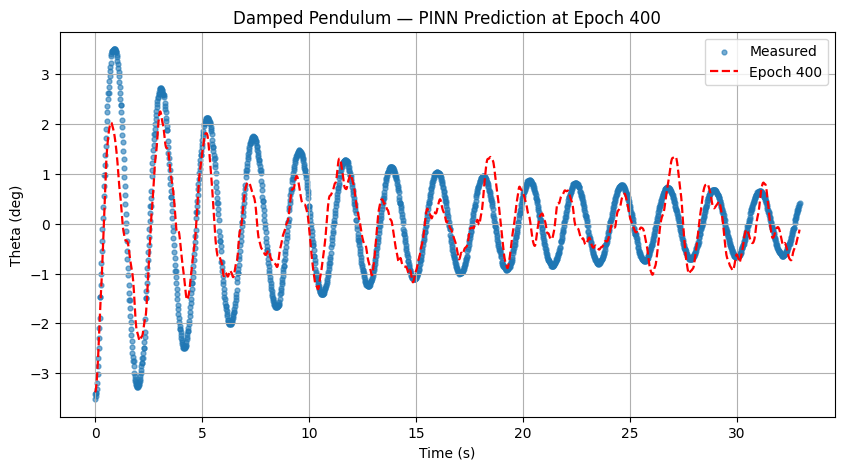

Epoch 0500 | total=1.310e-01 | data=8.559e-05 | pde=1.761e-01 | ic=2.866e-07
Epoch 0600 | total=9.550e-02 | data=5.590e-05 | pde=1.349e-01 | ic=1.547e-07


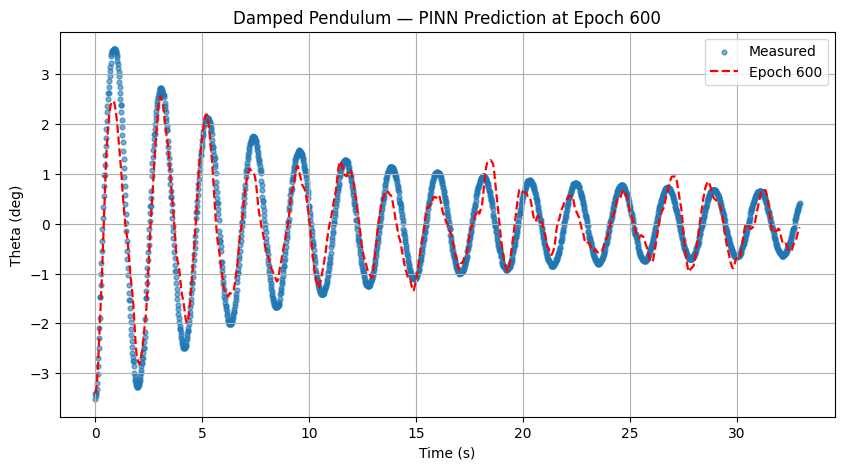

Epoch 0700 | total=7.179e-02 | data=3.777e-05 | pde=1.057e-01 | ic=8.954e-08
Epoch 0800 | total=5.529e-02 | data=2.657e-05 | pde=8.396e-02 | ic=5.774e-08


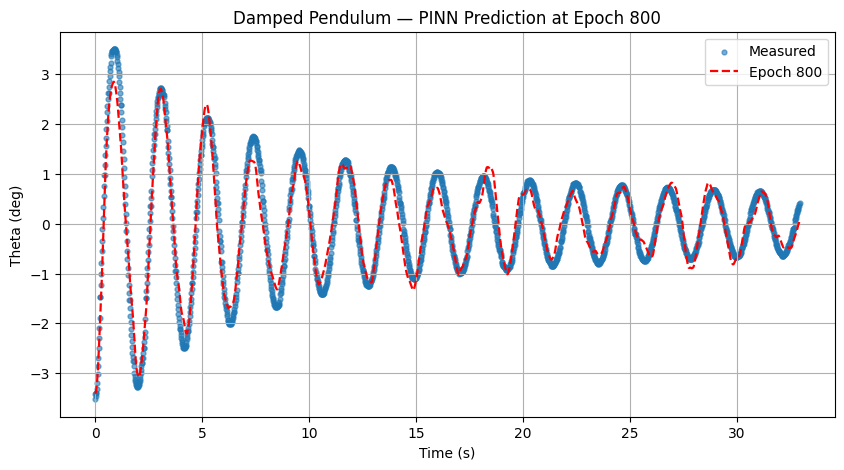

Epoch 0900 | total=4.342e-02 | data=1.934e-05 | pde=6.745e-02 | ic=4.106e-08
Epoch 1000 | total=3.466e-02 | data=1.443e-05 | pde=5.486e-02 | ic=3.095e-08


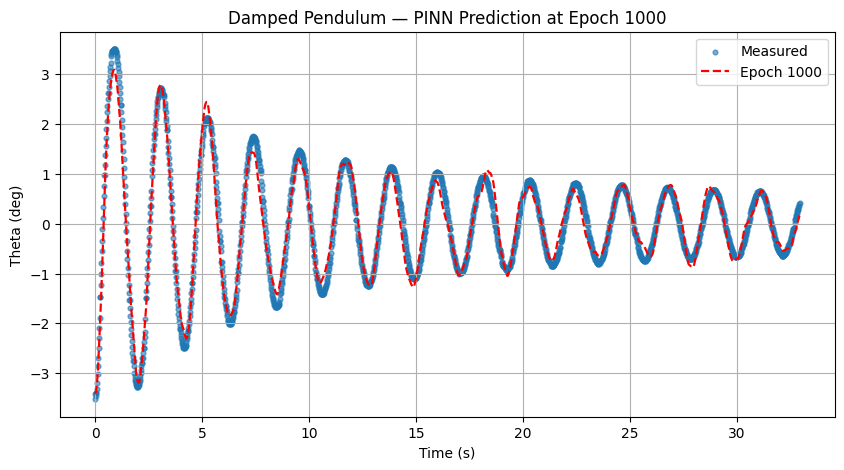

Epoch 1100 | total=2.810e-02 | data=1.098e-05 | pde=4.519e-02 | ic=2.396e-08
Epoch 1200 | total=2.311e-02 | data=8.495e-06 | pde=3.770e-02 | ic=1.871e-08


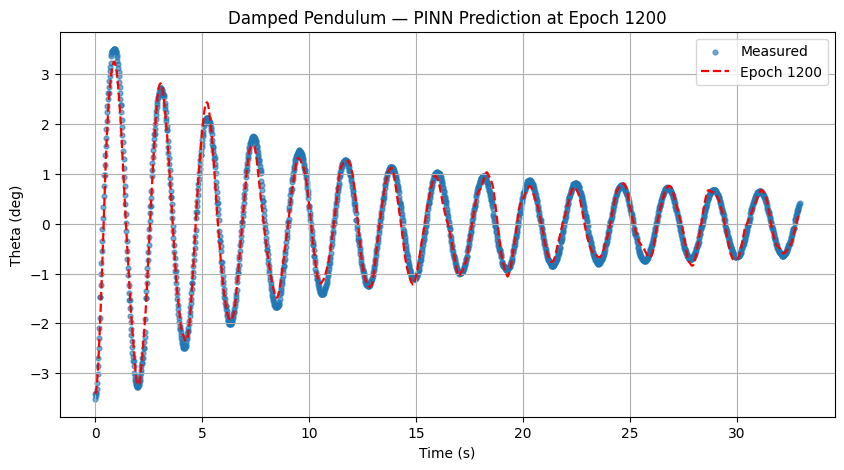

Epoch 1300 | total=1.928e-02 | data=6.698e-06 | pde=3.184e-02 | ic=1.468e-08
Epoch 1400 | total=1.631e-02 | data=5.406e-06 | pde=2.719e-02 | ic=1.163e-08


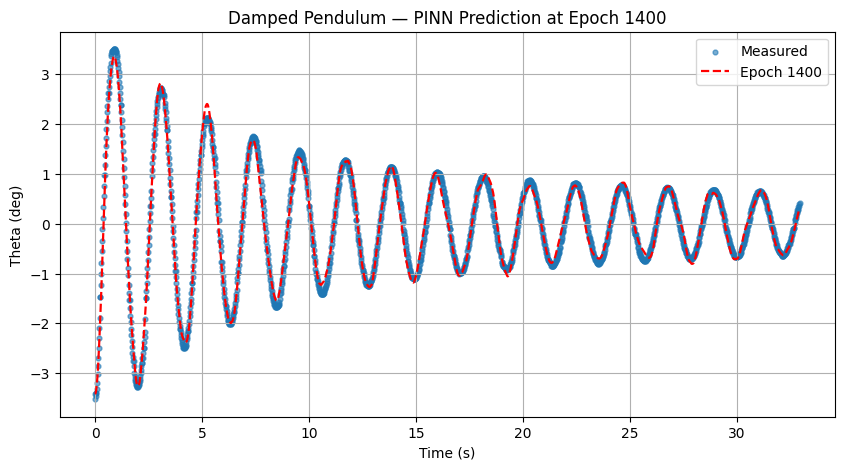

Epoch 1500 | total=1.398e-02 | data=4.482e-06 | pde=2.347e-02 | ic=9.386e-09
Epoch 1600 | total=1.214e-02 | data=3.816e-06 | pde=2.045e-02 | ic=7.698e-09


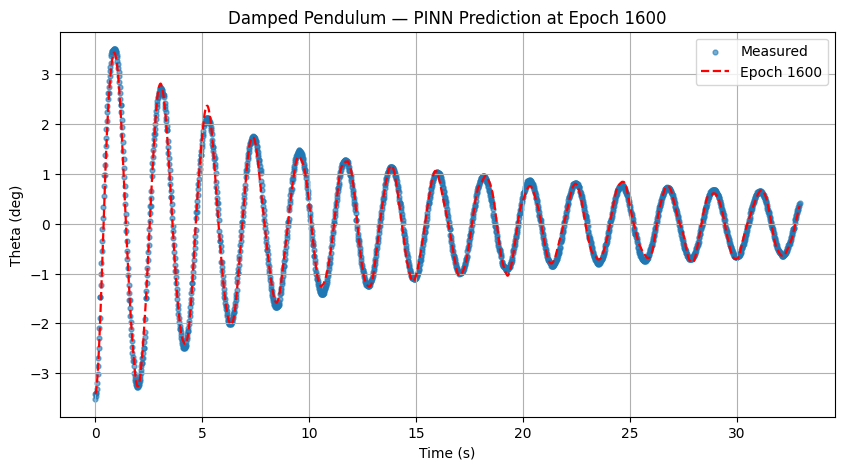

Epoch 1700 | total=1.066e-02 | data=3.328e-06 | pde=1.799e-02 | ic=6.482e-09
Epoch 1800 | total=9.461e-03 | data=2.963e-06 | pde=1.595e-02 | ic=5.558e-09


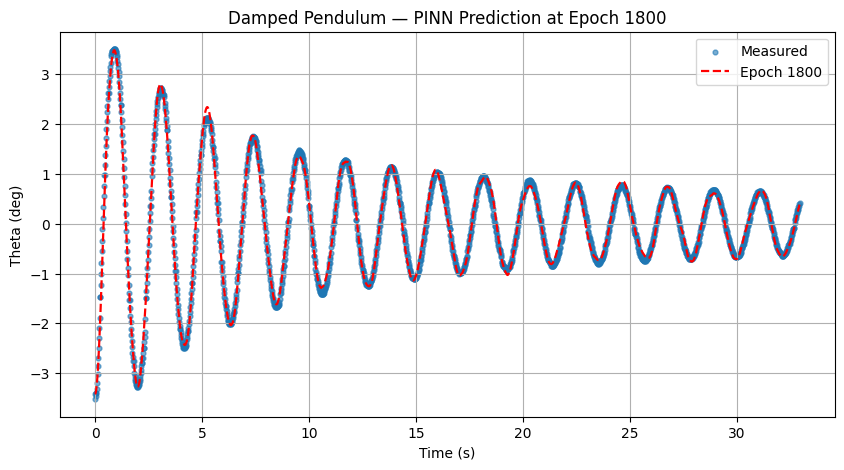

Epoch 1900 | total=8.474e-03 | data=2.682e-06 | pde=1.426e-02 | ic=4.894e-09
Epoch 2000 | total=7.651e-03 | data=2.462e-06 | pde=1.284e-02 | ic=4.404e-09


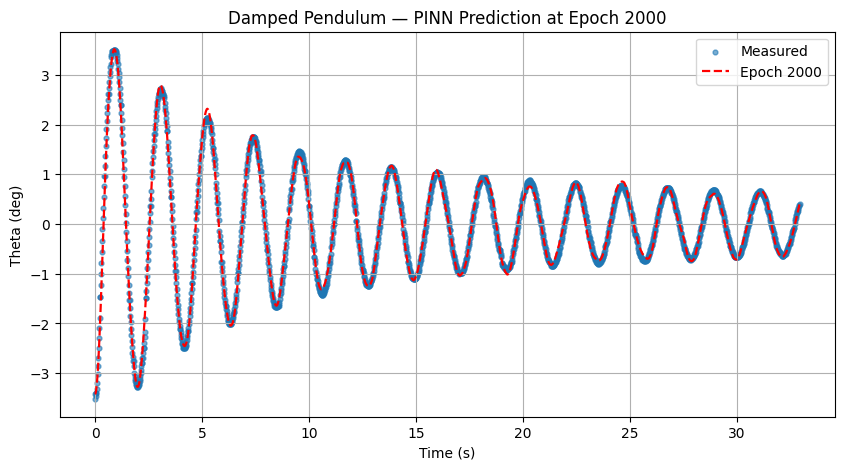

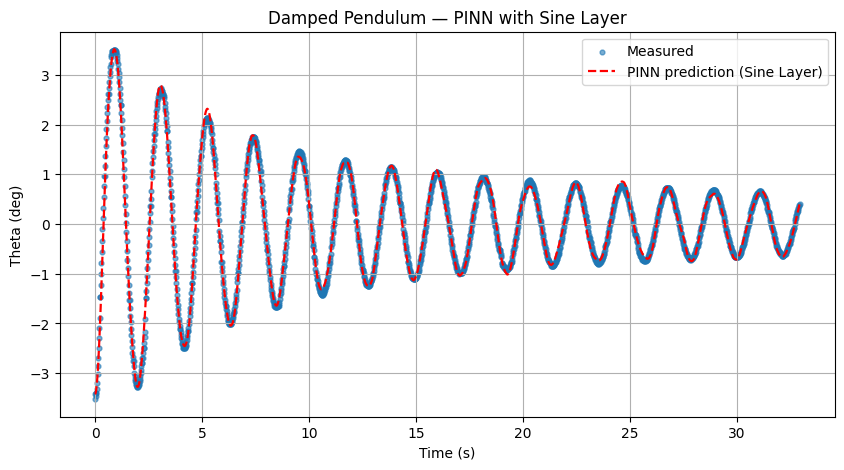

In [1]:
# ======================================================
# PINN for Damped Pendulum (with Sine First Layer)
# ======================================================
import jax
import jax.numpy as jnp
import equinox as eqx
import optax
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.tree_util as jtu

# ------------------ 1. Load data ------------------
df = pd.read_csv("transformed_data.csv")
t_np = df["Time"].to_numpy(dtype=np.float32).reshape(-1, 1)
theta_deg_np = df["Theta_degrees"].to_numpy(dtype=np.float32).reshape(-1, 1)
theta_np = np.deg2rad(theta_deg_np)
t_np -= t_np.min()

t_data = jnp.array(t_np)
theta_data = jnp.array(theta_np)

# ------------------ 2. Parameters ------------------
g = 9.81
L = 1.16
gamma = 0.143
theta0 = float(theta_np[0, 0])
theta_dot0 = 0.0

# ------------------ 3. Define Sine Layer ------------------
class SineLayer(eqx.Module):
    W: jnp.ndarray
    b: jnp.ndarray
    omega_0: float

    def __init__(self, key, in_size, out_size, omega_0=10.0):
        k1, k2 = jax.random.split(key)
        self.W = jax.random.normal(k1, (out_size, in_size)) * omega_0
        self.b = jax.random.uniform(k2, (out_size,)) * 2 * jnp.pi
        self.omega_0 = omega_0

    def __call__(self, x):
        return jnp.sin(jnp.dot(self.W, x) + self.b)

# ------------------ 4. MLP with Sine first layer ------------------
class MLP(eqx.Module):
    sine: SineLayer
    layers: list

    def __init__(self, key, in_size=1, out_size=1, width=64, depth=3, omega_0=10.0):
        k1, *keys = jax.random.split(key, depth + 2)
        self.sine = SineLayer(k1, in_size, width, omega_0)
        self.layers = []
        for i in range(depth):
            self.layers.append(eqx.nn.Linear(width, width, key=keys[i]))
        self.layers.append(eqx.nn.Linear(width, out_size, key=keys[-1]))

    def __call__(self, t):
        x = self.sine(t)
        for lyr in self.layers[:-1]:
            x = jnp.tanh(lyr(x))
        out = self.layers[-1](x)
        return jnp.squeeze(out)

# ------------------ 5. Physics residual ------------------
def physics_residual(model, t):
    t_flat = t.flatten()

    def f(s):
        return model(jnp.array([s]))

    theta_v = jax.vmap(f)(t_flat)
    theta_t_v = jax.vmap(jax.grad(f))(t_flat)
    theta_tt_v = jax.vmap(jax.grad(jax.grad(f)))(t_flat)

    res_v = theta_tt_v + gamma * theta_t_v + (g / L) * jnp.sin(theta_v)
    return theta_v.reshape(-1, 1), theta_t_v.reshape(-1, 1), theta_tt_v.reshape(-1, 1), res_v.reshape(-1, 1)

# ------------------ 6. Loss ------------------
def loss_fn(model, t, theta_obs, w_data=500.0, w_phys=0.5, w_ic=500.0):
    theta_pred, _, _, res = physics_residual(model, t)
    data_loss = jnp.mean((theta_pred - theta_obs) ** 2)
    phys_loss = jnp.mean(res ** 2)

    theta0_pred = model(jnp.array([0.0]))
    theta_dot0_pred = jax.grad(lambda s: model(jnp.array([s])))(0.0)
    ic_loss = (theta0_pred - theta0) ** 2 + (theta_dot0_pred - theta_dot0) ** 2

    total = w_data * data_loss + w_phys * phys_loss + w_ic * ic_loss
    return total, (data_loss, phys_loss, ic_loss)

# ------------------ 7. Setup model and optimizer ------------------
key = jax.random.PRNGKey(0)
model = MLP(key, in_size=1, out_size=1, width=128, depth=3, omega_0=10.0)

diff_model, static_model = eqx.partition(model, eqx.is_inexact_array)

opt = optax.adam(5e-4)
opt_state = opt.init(eqx.filter(diff_model, eqx.is_inexact_array))

fvag = eqx.filter_value_and_grad(lambda dm, sm: loss_fn(eqx.combine(dm, sm), t_data, theta_data), has_aux=True)

@eqx.filter_jit
def step(opt_state, diff_m, static_m):
    (loss_val, aux), grads = fvag(diff_m, static_m)
    updates, opt_state = opt.update(grads, opt_state, eqx.filter(diff_m, eqx.is_inexact_array))
    diff_m = eqx.apply_updates(diff_m, updates)
    return opt_state, diff_m, loss_val, aux

# ------------------ 8. Training loop with intermediate plots ------------------
n_epochs = 2000
plot_interval = 200  # plot every 200 epochs

print("Starting training...")
for epoch in range(1, n_epochs+1):
    opt_state, diff_model, loss_val, aux = step(opt_state, diff_model, static_model)

    if epoch % 100 == 0 or epoch == 1:
        d, p, ic = aux
        print(f"Epoch {epoch:04d} | total={float(loss_val):.3e} | data={float(d):.3e} | pde={float(p):.3e} | ic={float(ic):.3e}")

    # Plot prediction at every plot_interval epochs
    if epoch % plot_interval == 0:
        trained = eqx.combine(diff_model, static_model)
        t_flat = t_np.flatten()
        theta_pred = jax.vmap(lambda s: trained(jnp.array([s])))(t_flat)
        theta_pred_deg = np.degrees(np.array(theta_pred).flatten())
        theta_meas_deg = theta_deg_np.flatten()

        plt.figure(figsize=(10,5))
        plt.scatter(t_flat, theta_meas_deg, s=12, alpha=0.6, label="Measured")
        plt.plot(t_flat, theta_pred_deg, 'r--', lw=1.6, label=f"Epoch {epoch}")
        plt.xlabel("Time (s)")
        plt.ylabel("Theta (deg)")
        plt.legend()
        plt.grid(True)
        plt.title(f"Damped Pendulum — PINN Prediction at Epoch {epoch}")
        plt.show()

# ------------------ 9. Evaluate & plot ------------------
trained = eqx.combine(diff_model, static_model)
t_flat = t_np.flatten()
theta_pred = jax.vmap(lambda s: trained(jnp.array([s])))(t_flat)
theta_pred_deg = np.degrees(np.array(theta_pred).flatten())
theta_meas_deg = theta_deg_np.flatten()

plt.figure(figsize=(10,5))
plt.scatter(t_flat, theta_meas_deg, s=12, alpha=0.6, label="Measured")
plt.plot(t_flat, theta_pred_deg, 'r--', lw=1.6, label="PINN prediction (Sine Layer)")
plt.xlabel("Time (s)")
plt.ylabel("Theta (deg)")
plt.legend()
plt.grid(True)
plt.title("Damped Pendulum — PINN with Sine Layer")
plt.show()
